<a href="https://colab.research.google.com/github/brunocosouza/deep_learning/blob/main/keras_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from   tensorflow import keras
from   skimage.color import rgb2lab
from   tensorflow.keras.utils import to_categorical
from   tensorflow.keras import layers
from   tensorflow.keras import models
from   tensorflow.keras import optimizers
from   tensorflow.keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

### Load training, validation, and testing images from their numpy arrays together with their labels 

In [ ]:
X_train   = np.load('X_train.npy')
Y_train   = np.load('Y_train.npy')
X_valid   = np.load('X_valid.npy')
Y_valid   = np.load('Y_valid.npy')
X_test    = np.load('X_test.npy')
Y_test    = np.load('Y_test.npy')
xsize     = X_train.shape[1]
ysize     = X_train.shape[2]
nchannels = X_train.shape[3]
nclasses  = np.amax(Y_train) + 1

if (nclasses > 2):
    Y_train = to_categorical(Y_train)
    Y_valid = to_categorical(Y_valid)
    Y_test  = to_categorical(Y_test)

model_basename = 'corel'

### ConvNet model for Corel: try options with and without residual layers

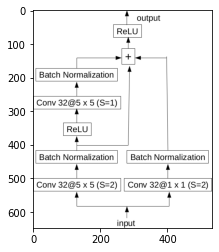

In [ ]:
from functools import partial
import matplotlib.image as mpimg

# Show residual layer 

img = mpimg.imread('./residual_layer.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, padding="same")

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters=32, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, kernel_size=(5,5), strides=(2,2)),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters, kernel_size=(5,5), strides=(1,1)),
            keras.layers.BatchNormalization()]
        self.skip_layers = [
                DefaultConv2D(filters, kernel_size=(1,1), strides=(2,2)),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for i, layer in enumerate(self.main_layers):
            Z = layer(Z)
            if (i == 1):
                Z1 = Z
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + Z1 + skip_Z)
        
def ModelForCorel(nclasses, lr, padding_opt, initializer_opt, residual_model): 
    model = models.Sequential()
    if (residual_model):
        model.add(ResidualUnit(filters=32))
        model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2), name='pool1_1', padding=padding_opt))
    else:
        model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name='conv1_1', 
                            dilation_rate=(1,1), 
                            activation=None, input_shape=(xsize,ysize,nchannels), 
                            padding=padding_opt, 
                            kernel_initializer=initializer_opt))
        model.add(layers.BatchNormalization(name='bn1_1'))
        model.add(layers.ReLU(max_value=None, negative_slope=0, name='relu1_1', threshold=0))
        model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), 
                                  name='pool1_1', padding=padding_opt)) 
        model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), name='conv2_1', 
                            dilation_rate=(1,1), padding=padding_opt, activation=None, 
                            kernel_initializer=initializer_opt))
        model.add(layers.BatchNormalization(name='bn2_1'))
        model.add(layers.ReLU(max_value=None, negative_slope=0, name='relu2_1', threshold=0))
        model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2), name='pool2_1', padding=padding_opt))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, name='dense1', activation='relu', 
                 kernel_initializer=initializer_opt, kernel_regularizer=tf.keras.regularizers.l2(0.2)))
    model.add(layers.Dropout(0.5))
    # For categorical datasets (classes are 0,1,2,...,c-1)
    model.add(layers.Dense(nclasses, activation='softmax', name='decision', kernel_initializer=initializer_opt, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.2)))
    opt = optimizers.Adam(learning_rate=lr)
    #opt = optimizers.RMSprop(learning_rate=lr)
    #opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
 
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    return(model)

### Define a ConvNet: You can play with its architecture and parameters. Note that, as you add more layers (i.e., parameters), more epochs might be required for training the model with no overfitting.   

In [ ]:
keras.backend.clear_session() # clean memory from previous models 
np.random.seed(42)            
tf.random.set_seed(42)

# Model to process the dataset
residual_model  = False
lr              = 1e-6
padding_opt     = 'same'           # same, valid
initializer_opt = 'he_uniform'     # he_uniform, lecun_normal

model = ModelForCorel(nclasses, lr, padding_opt, initializer_opt, residual_model)

### Train the model and visualize its summary, training and validation loss curves

In [ ]:
nepochs   = 20
batchsize = 20

def exponential_decay(epoch):
    return(lr*0.1**(epoch/nepochs))

def TrainModel(model, batchsize, nepochs, model_basename, residual_model):
    lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)
    my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=max(2,nepochs/5), restore_best_weights=True), 
                    tf.keras.callbacks.ModelCheckpoint(model_basename, save_best_only=True), 
                    lr_scheduler]
    if (residual_model):
        history      = model.fit(X_train,Y_train,epochs=nepochs,
                                 batch_size=batchsize, 
                                 validation_data=(X_valid,Y_valid))
    else:
        history      = model.fit(X_train,Y_train,epochs=nepochs,
                                 batch_size=batchsize, 
                                 validation_data=(X_valid,Y_valid), callbacks = my_callbacks)
    return(history)

history = TrainModel(model, batchsize, nepochs, model_basename, residual_model)

Epoch 1/20
11/11 [==============================] - 28s 2s/step - loss: 209.3117 - acc: 0.2817 - val_loss: 211.1926 - val_acc: 0.3239
INFO:tensorflow:Assets written to: corel/assets
Epoch 2/20
11/11 [==============================] - 26s 2s/step - loss: 208.2518 - acc: 0.4977 - val_loss: 208.7120 - val_acc: 0.5352
INFO:tensorflow:Assets written to: corel/assets
Epoch 3/20
11/11 [==============================] - 26s 2s/step - loss: 207.6403 - acc: 0.6479 - val_loss: 208.3063 - val_acc: 0.5775
INFO:tensorflow:Assets written to: corel/assets
Epoch 4/20
11/11 [==============================] - 26s 2s/step - loss: 207.1903 - acc: 0.7089 - val_loss: 207.6957 - val_acc: 0.5915
INFO:tensorflow:Assets written to: corel/assets
Epoch 5/20
11/11 [==============================] - 26s 2s/step - loss: 206.9054 - acc: 0.8169 - val_loss: 207.3716 - val_acc: 0.6056
INFO:tensorflow:Assets written to: corel/assets
Epoch 6/20
11/11 [==============================] - 26s 2s/step - loss: 206.6816 - acc: 0.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 200, 200, 32)      896       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, 200, 200, 32)      128       
_________________________________________________________________
relu1_1 (ReLU)               (None, 200, 200, 32)      0         
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 100, 100, 32)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 100, 64)      18496     
_________________________________________________________________
bn2_1 (BatchNormalization)   (None, 100, 100, 64)      256       
_________________________________________________________________
relu2_1 (ReLU)               (None, 100, 100, 64)      0

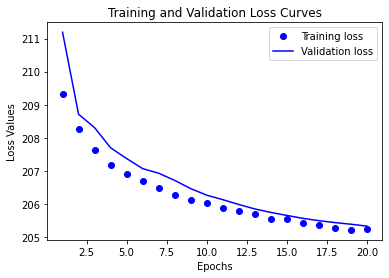

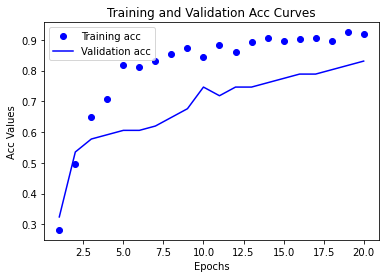

In [ ]:
def PlotHistory(history):
    history_dict    = history.history
    train_loss      = history_dict['loss']
    valid_loss      = history_dict['val_loss']
    epochs          = [ i for i in range(1, len(train_loss)+1)]
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, valid_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.legend()
    plt.show()
    plt.clf() # Clear the figure
    train_acc       = history_dict['acc']
    valid_acc       = history_dict['val_acc']
    plt.plot(epochs, train_acc, 'bo', label='Training acc')
    plt.plot(epochs, valid_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Acc Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Acc Values')
    plt.legend()
    plt.show()
    
# prints the model and the training history
model.summary()    
PlotHistory(history)

### Save model

In [ ]:
if (residual_model):
    model.save(model_basename+'.tf')
else:
    model.save(model_basename+'.h5')
    
#model = tf.keras.models.load_model(model_basename+'.tf')    
#model = tf.keras.models.load_model(model_basename+'.h5')    

### Evaluate model

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=1)

3/3 [==============================] - 2s 461ms/step - loss: 205.4317 - acc: 0.7887


## AlexNet

In [ ]:
model_alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(xsize,ysize,nchannels)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(nclasses, activation='softmax')
])

In [ ]:
import matplotlib.pyplot as plt
import os
import time

root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
model_alex.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.SGD(lr=0.001), metrics=['acc'])
model_alex.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 23, 23, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 384)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)
my_callback = [tf.keras.callbacks.EarlyStopping(patience=max(2,nepochs/5), restore_best_weights=True), lr_scheduler]

history = model_alex.fit(X_train, Y_train,
               batch_size = batchsize,
               epochs=20,
               validation_data=(X_valid,Y_valid),
               callbacks = my_callbacks)

Epoch 1/20
11/11 [==============================] - 26s 2s/step - loss: 2.7690 - acc: 0.3099 - val_loss: 2.9015 - val_acc: 0.1831
Epoch 2/20
11/11 [==============================] - 25s 2s/step - loss: 1.6094 - acc: 0.5587 - val_loss: 2.3773 - val_acc: 0.2113
Epoch 3/20
11/11 [==============================] - 25s 2s/step - loss: 1.2103 - acc: 0.6291 - val_loss: 2.0803 - val_acc: 0.2113
Epoch 4/20
11/11 [==============================] - 25s 2s/step - loss: 0.8924 - acc: 0.6761 - val_loss: 1.4003 - val_acc: 0.4366
Epoch 5/20
11/11 [==============================] - 25s 2s/step - loss: 0.6442 - acc: 0.7934 - val_loss: 1.6254 - val_acc: 0.3521
Epoch 6/20
11/11 [==============================] - 25s 2s/step - loss: 0.6489 - acc: 0.7512 - val_loss: 1.5963 - val_acc: 0.3099
Epoch 7/20
11/11 [==============================] - 25s 2s/step - loss: 0.4988 - acc: 0.8263 - val_loss: 0.9794 - val_acc: 0.5634
Epoch 8/20
11/11 [==============================] - 25s 2s/step - loss: 0.3168 - acc: 0.90

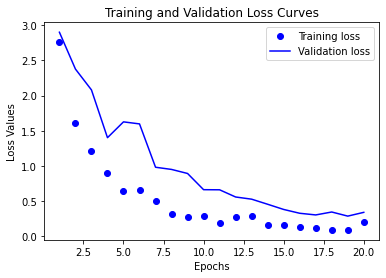

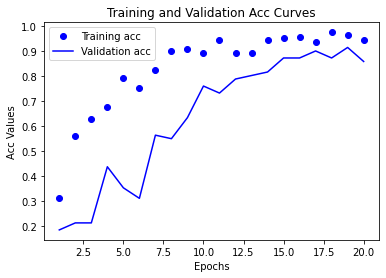

In [ ]:
PlotHistory(model_alex.history)

In [ ]:
scores = model_alex.evaluate(X_test, Y_test, verbose=1)

3/3 [==============================] - 2s 502ms/step - loss: 0.4036 - acc: 0.8592


In [ ]:
model_alex.save('model_alex.h5')